# Import libraries

In [308]:
import os
import cv2
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

### Some constants ###
input_dim = 12 # 48
weights_dir = 'road_signs'
tensorboard_logdir = 'pnet_logs'
pnet_weights = f'weights/{weights_dir}/pnet.weights.hdf5'

if(not os.path.exists(f'weights/{weights_dir}')):
    print('[INFO] Created weight directory ...')
    os.mkdir(f'weights/{weights_dir}')
    
if(os.path.exists(tensorboard_logdir)):
    shutil.rmtree(tensorboard_logdir)

epochs = 500
batch_size = 16
tensorboard = TensorBoard(log_dir=tensorboard_logdir)
checkpoint = ModelCheckpoint('weights/pnet.weights.hdf5', save_weights_only=True)
callbacks = [tensorboard, checkpoint]

train_dir = "/home/minhhieu/Desktop/Hieu/datasets/RoadSignDetection/images"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TestIJCNN2013/TestIJCNN2013Download"

# Load and explore dataset

In [313]:
def load_raw_dataset(dataset_dir, gt_file, delimiter=';', max_n_samples=3000):
    '''
        This function will take in a dataset directory with ppm images (according to the DTSDB dataset)
        then it will return a list where each element is a list of 3 items. First item is the image, the
        second item is the bounding box and the last is the class ID.
        
        Params :
            @dataset_dir : Dataset directory.
            @gt_file : The file that consists of ground truth annotation in the format
            <img_pth>;<left>;<top>;<right>;<bottom>;<class_idx>.
            @delimiter : The separator of each item in each line of the ground truth file
            
        Returns :
            raw_dataset : list of elements [<cv2_img>, <gt_bbox>, <class_idx>]
    '''
    gt_abs_path = os.path.join(dataset_dir, gt_file)
    class_ids = {}
    lines = open(gt_abs_path, 'r').readlines()
    
    print('[INFO] From images to ground truth ... ')
    images_to_gt = [[x.strip().split(delimiter)[0],   # Image path
                     x.strip().split(delimiter)[1:5], # Bbox regression ground truth
                     x.strip().split(delimiter)[5]]   # The class index
                    for x in lines]
    
    print('[INFO] Converting to raw dataset ... ')
    raw_dataset = [[cv2.cvtColor(cv2.imread(os.path.join(dataset_dir, x[0])), cv2.COLOR_BGR2RGB),
                    np.array(x[1]).astype('int'),
                    x[2]] 
                  for x in images_to_gt[:max_n_samples]]
    
    print(f'[INFO] {len(raw_dataset)} samples loaded ... ')
    
    return raw_dataset
    
# raw_dataset = load_raw_dataset(train_dir, 'gt.txt')

# ### Visualize sample data ###
# img = raw_dataset[1][0].copy()
# bbox = raw_dataset[1][1]
# x1, y1, x2, y2 = bbox
# img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
# plt.imshow(img)
# plt.show()

### Generating negative samples (samples without traffic signs)

In [314]:
def generate_neg_samples(raw_dataset, crop_size=(48, 48)):
    '''
        This function will generate croppings of fixed size without any traffic sign
        and return those croppings with dummy bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @crop_size : The fixed cropping size
            
        Return:
            neg_samples : A list in format [<crop_img>,<dummy_bbox>,0]
    '''
    neg_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        range_x = ((0, max(x1 - crop_size[0], 0)), (min(x2 + crop_size[0], width), width))
        range_y = ((0, max(y1 - crop_size[1], 0)), (min(y2 + crop_size[1], height), height))
        
        ### Generate a random x,y coordinates ###
        x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
        y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        # regenerate if cropping does not satisfy the size requirements
        while(width - x < crop_size[0] or height - y < crop_size[1]):
            x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                           random.randint(range_x[1][0], range_x[1][1])])
            y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                           random.randint(range_y[1][0], range_y[1][1])])
        
        crop = img[y:y+crop_size[1], x:x+crop_size[0]]
        neg_samples.append([crop, np.array([0,0,0,0]), 0])
        
    print(f'[INFO] {len(neg_samples)} negative samples generated ... ')
    return np.array(neg_samples)

# neg_samples = generate_neg_samples(raw_dataset, crop_size=(input_dim,input_dim))
# plt.imshow(neg_samples[1][0].copy())
# plt.show()

### Generate positive samples (samles with traffic signs)

In [315]:
def generate_pos_samples(raw_dataset, pad_range=(10, 100), img_size=48):
    '''
        This function will generate croppings with traffic signs
        and return those croppings with bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @pad_range : The pad range around the ground truth bounding box
            
        Return:
            pos_samples : A list in format [<crop_img>,<bbox>,1]
    '''
    pos_samples = []
    for img, bbox, class_id in raw_dataset:
        height, width = img.shape[:2]
        x1, y1, x2, y2 = bbox
        pad_x1 = min(x1, random.randint(pad_range[0], pad_range[1]))
        pad_x2 = min(width - x2, random.randint(pad_range[0], pad_range[1]))
        pad_y1 = min(y1, random.randint(pad_range[0], pad_range[1]))
        pad_y2 = min(height - y2, random.randint(pad_range[0], pad_range[1]))
        
        crop = img[y1 - pad_y1:y2 + pad_y2, x1 - pad_x1:x2 + pad_x2]
        h, w = crop.shape[:2]
        
        gt = np.array([pad_x1, pad_y1, pad_x1 + x2 - x1, pad_y1 + y2 - y1])
        gt[2] = gt[2] - gt[0] # Calculates width
        gt[3] = gt[3] - gt[1] # Calculates height
        gt = np.multiply(gt, np.array([1/w, 1/h, 1/w, 1/h])).astype('float32')
        
        crop = cv2.resize(crop, (img_size, img_size))
        pos_samples.append([crop, gt, class_id])
        
    print(f'[INFO] {len(pos_samples)} positive samples generated ... ')
    return np.array(pos_samples)

# pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 15), img_size=input_dim)

# img, gt, label = pos_samples[6]
# img = img.copy()
# h, w = img.shape[:2]
# x1, y1, w, h = np.multiply(gt, np.array([w,h,w,h])).astype('int')

# img = cv2.rectangle(img, (x1, y1), (x1+w, y1+h), 2)
# plt.imshow(img)
# plt.show()

### Combine negative and positive samples to form training dataset

In [329]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, crop_size=(input_dim,input_dim))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 15), img_size=input_dim)
pos_samples[:,2] = LabelEncoder().fit_transform(pos_samples[:, 2])
pos_samples[:,2] += 1

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 1244 negative samples generated ... 
[INFO] 1244 positive samples generated ... 


# Implement P-Net architecture

In [332]:
def conv_block(in_filters, out_filters, kernel_size=3, batch_norm=False):
    inputs = Input(shape=(None, None, in_filters))
    p_layer = Conv2D(out_filters, kernel_size=kernel_size, strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)
    
    block = Model(inputs = inputs, outputs=p_layer)
    return block

def build_pnet_model(input_shape=None, batch_norm=True, dropout=False, n_classes=2):
    if(input_shape is not None):
        if(input_shape not in [12, 24, 48, 112, 224]):
            raise Exception('Input shape must be in 12, 24, 48')
    
    inputs = Input(shape=(None, None, 3))
    p_layer = conv_block(3, 10, kernel_size=3, batch_norm=batch_norm)(inputs)
    
    if(input_shape is not None):
        if(input_shape >= 24):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(inputs)
    
    if(input_shape is not None):
        if(input_shape >= 48):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(inputs)
            
    if(input_shape is not None):
        if(input_shape >= 112):
            for i in range(1):
                p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(inputs)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)

    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(n_classes, kernel_size=(1, 1), strides=(2, 2))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)
    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(2, 2), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net

n_classes = train_labels.shape[3]
pnet = build_pnet_model(input_shape=12, batch_norm=True, dropout=True, n_classes=n_classes)
print(pnet(tf.random.normal((1,12,12,3)))[1].shape)
print(pnet.summary())

(1, 1, 1, 4)
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_17 (Functional)      (None, None, None, 1 330         input_32[0][0]                   
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, None, None, 1 1456        functional_17[0][0]              
__________________________________________________________________________________________________
p_re_lu_96 (PReLU)              (None, None, None, 1 16          conv2d_119[0][0]                 
_________________________________________________________________________________

# Start training

In [333]:
losses = {
    'probability' : BinaryCrossentropy(),
    'bbox_regression' : MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)
pnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

In [334]:
history = pnet.fit(train_images, y, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/500
156/156 [==============================] - 0s 2ms/step - loss: 0.7078 - probability_loss: 0.5093 - bbox_regression_loss: 0.1906 - probability_accuracy: 0.2749
Epoch 2/500
156/156 [==============================] - 0s 2ms/step - loss: 0.6963 - probability_loss: 0.5047 - bbox_regression_loss: 0.1838 - probability_accuracy: 0.3087
Epoch 3/500
156/156 [==============================] - 0s 2ms/step - loss: 0.6814 - probability_loss: 0.4943 - bbox_regression_loss: 0.1793 - probability_accuracy: 0.3477
Epoch 4/500
156/156 [==============================] - 0s 2ms/step - loss: 0.6730 - probability_loss: 0.4926 - bbox_regression_loss: 0.1726 - probability_accuracy: 0.3790
Epoch 5/500
156/156 [==============================] - 0s 2ms/step - loss: 0.6634 - probability_loss: 0.4881 - bbox_regression_loss: 0.1675 - probability_accuracy: 0.3963
Epoch 6/500
156/156 [==============================] - 0s 2ms/step - loss: 0.6512 - probability_loss: 0.4802 - bbox_regression_loss: 0.1632 - pro

156/156 [==============================] - 0s 2ms/step - loss: 0.4097 - probability_loss: 0.3367 - bbox_regression_loss: 0.0651 - probability_accuracy: 0.6250
Epoch 47/500
156/156 [==============================] - 0s 2ms/step - loss: 0.4048 - probability_loss: 0.3319 - bbox_regression_loss: 0.0650 - probability_accuracy: 0.6342
Epoch 48/500
156/156 [==============================] - 0s 2ms/step - loss: 0.4046 - probability_loss: 0.3327 - bbox_regression_loss: 0.0640 - probability_accuracy: 0.6302
Epoch 49/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3990 - probability_loss: 0.3276 - bbox_regression_loss: 0.0635 - probability_accuracy: 0.6306
Epoch 50/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3966 - probability_loss: 0.3270 - bbox_regression_loss: 0.0617 - probability_accuracy: 0.6367
Epoch 51/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3939 - probability_loss: 0.3251 - bbox_regression_loss: 0.0609 - probabilit

156/156 [==============================] - 0s 2ms/step - loss: 0.3383 - probability_loss: 0.2867 - bbox_regression_loss: 0.0436 - probability_accuracy: 0.6789
Epoch 94/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3327 - probability_loss: 0.2826 - bbox_regression_loss: 0.0421 - probability_accuracy: 0.6773
Epoch 95/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3321 - probability_loss: 0.2827 - bbox_regression_loss: 0.0415 - probability_accuracy: 0.6720
Epoch 96/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3361 - probability_loss: 0.2862 - bbox_regression_loss: 0.0419 - probability_accuracy: 0.6756
Epoch 97/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3332 - probability_loss: 0.2843 - bbox_regression_loss: 0.0410 - probability_accuracy: 0.6785
Epoch 98/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3319 - probability_loss: 0.2825 - bbox_regression_loss: 0.0414 - probabilit

156/156 [==============================] - 0s 2ms/step - loss: 0.3013 - probability_loss: 0.2613 - bbox_regression_loss: 0.0319 - probability_accuracy: 0.6957
Epoch 141/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3047 - probability_loss: 0.2647 - bbox_regression_loss: 0.0320 - probability_accuracy: 0.6909
Epoch 142/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3026 - probability_loss: 0.2626 - bbox_regression_loss: 0.0319 - probability_accuracy: 0.6901
Epoch 143/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3019 - probability_loss: 0.2632 - bbox_regression_loss: 0.0307 - probability_accuracy: 0.6965
Epoch 144/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3092 - probability_loss: 0.2686 - bbox_regression_loss: 0.0325 - probability_accuracy: 0.6825
Epoch 145/500
156/156 [==============================] - 0s 2ms/step - loss: 0.3028 - probability_loss: 0.2635 - bbox_regression_loss: 0.0313 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2860 - probability_loss: 0.2511 - bbox_regression_loss: 0.0269 - probability_accuracy: 0.7030
Epoch 188/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2868 - probability_loss: 0.2519 - bbox_regression_loss: 0.0268 - probability_accuracy: 0.7058
Epoch 189/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2857 - probability_loss: 0.2500 - bbox_regression_loss: 0.0277 - probability_accuracy: 0.7038
Epoch 190/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2815 - probability_loss: 0.2475 - bbox_regression_loss: 0.0259 - probability_accuracy: 0.7038
Epoch 191/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2861 - probability_loss: 0.2522 - bbox_regression_loss: 0.0258 - probability_accuracy: 0.7078
Epoch 192/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2812 - probability_loss: 0.2476 - bbox_regression_loss: 0.0256 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2730 - probability_loss: 0.2405 - bbox_regression_loss: 0.0244 - probability_accuracy: 0.7130
Epoch 235/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2715 - probability_loss: 0.2398 - bbox_regression_loss: 0.0236 - probability_accuracy: 0.7283
Epoch 236/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2714 - probability_loss: 0.2389 - bbox_regression_loss: 0.0244 - probability_accuracy: 0.7191
Epoch 237/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2758 - probability_loss: 0.2433 - bbox_regression_loss: 0.0244 - probability_accuracy: 0.7074
Epoch 238/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2668 - probability_loss: 0.2350 - bbox_regression_loss: 0.0237 - probability_accuracy: 0.7263
Epoch 239/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2709 - probability_loss: 0.2390 - bbox_regression_loss: 0.0238 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2607 - probability_loss: 0.2313 - bbox_regression_loss: 0.0213 - probability_accuracy: 0.7239
Epoch 282/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2598 - probability_loss: 0.2298 - bbox_regression_loss: 0.0220 - probability_accuracy: 0.7359
Epoch 283/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2634 - probability_loss: 0.2334 - bbox_regression_loss: 0.0219 - probability_accuracy: 0.7295
Epoch 284/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2607 - probability_loss: 0.2308 - bbox_regression_loss: 0.0218 - probability_accuracy: 0.7404
Epoch 285/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2621 - probability_loss: 0.2318 - bbox_regression_loss: 0.0222 - probability_accuracy: 0.7191
Epoch 286/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2665 - probability_loss: 0.2363 - bbox_regression_loss: 0.0221 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2596 - probability_loss: 0.2307 - bbox_regression_loss: 0.0208 - probability_accuracy: 0.7319
Epoch 329/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2570 - probability_loss: 0.2288 - bbox_regression_loss: 0.0201 - probability_accuracy: 0.7323
Epoch 330/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2568 - probability_loss: 0.2281 - bbox_regression_loss: 0.0206 - probability_accuracy: 0.7383
Epoch 331/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2535 - probability_loss: 0.2247 - bbox_regression_loss: 0.0207 - probability_accuracy: 0.7520
Epoch 332/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2546 - probability_loss: 0.2262 - bbox_regression_loss: 0.0203 - probability_accuracy: 0.7295
Epoch 333/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2517 - probability_loss: 0.2234 - bbox_regression_loss: 0.0201 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2478 - probability_loss: 0.2203 - bbox_regression_loss: 0.0194 - probability_accuracy: 0.7420
Epoch 375/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2476 - probability_loss: 0.2204 - bbox_regression_loss: 0.0192 - probability_accuracy: 0.7480
Epoch 376/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2480 - probability_loss: 0.2214 - bbox_regression_loss: 0.0185 - probability_accuracy: 0.7387
Epoch 377/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2515 - probability_loss: 0.2244 - bbox_regression_loss: 0.0190 - probability_accuracy: 0.7436
Epoch 378/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2534 - probability_loss: 0.2253 - bbox_regression_loss: 0.0200 - probability_accuracy: 0.7371
Epoch 379/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2515 - probability_loss: 0.2236 - bbox_regression_loss: 0.0198 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2472 - probability_loss: 0.2199 - bbox_regression_loss: 0.0192 - probability_accuracy: 0.7480
Epoch 422/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2396 - probability_loss: 0.2130 - bbox_regression_loss: 0.0185 - probability_accuracy: 0.7617
Epoch 423/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2451 - probability_loss: 0.2181 - bbox_regression_loss: 0.0189 - probability_accuracy: 0.7504
Epoch 424/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2459 - probability_loss: 0.2191 - bbox_regression_loss: 0.0187 - probability_accuracy: 0.7460
Epoch 425/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2456 - probability_loss: 0.2192 - bbox_regression_loss: 0.0183 - probability_accuracy: 0.7383
Epoch 426/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2405 - probability_loss: 0.2144 - bbox_regression_loss: 0.0180 - proba

156/156 [==============================] - 0s 2ms/step - loss: 0.2406 - probability_loss: 0.2146 - bbox_regression_loss: 0.0179 - probability_accuracy: 0.7609
Epoch 469/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2412 - probability_loss: 0.2153 - bbox_regression_loss: 0.0177 - probability_accuracy: 0.7621
Epoch 470/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2346 - probability_loss: 0.2095 - bbox_regression_loss: 0.0170 - probability_accuracy: 0.7689
Epoch 471/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2393 - probability_loss: 0.2131 - bbox_regression_loss: 0.0180 - probability_accuracy: 0.7592
Epoch 472/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2354 - probability_loss: 0.2099 - bbox_regression_loss: 0.0173 - probability_accuracy: 0.7621
Epoch 473/500
156/156 [==============================] - 0s 2ms/step - loss: 0.2399 - probability_loss: 0.2140 - bbox_regression_loss: 0.0177 - proba

# Test P-Net proposals

In [335]:
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

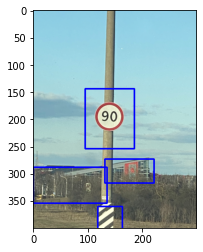

In [355]:
raw_img = cv2.imread(os.path.join(train_dir, 'road789.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road783.png'))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

def get_bboxes_pnet(raw_img, threshold=0.5, nms_threshold=0.3,
                    scale_factor=2.0, min_img_size = 48, padding = 0.15):
    '''
        
    '''
    H, W = raw_img.shape[:2]
    images = [raw_img]
    current_h, current_w = raw_img.shape[:2]
    
    ### 1. Get image pyramid ###
    while(current_h > min_img_size and current_w > min_img_size):
        current_h = int(current_h / scale_factor)
        current_w = int(current_w / scale_factor)

        if(current_w < min_img_size or current_h < min_img_size) : break

        image = cv2.resize(raw_img, (current_w, current_h))
        images.append(image)

    ### 2. Get bounding boxes from each image in the pyramid ###
    boxes = []
    for i, image in enumerate(images):
        if(i == 0): scale = 1
        else : scale = scale_factor ** i

        img = (image - 127.5) / 127.5
        height, width = image.shape[:2]

        predictions = pnet.predict(np.array([img]))
        features_shape = predictions[1][0].shape[:2]

        scale_w = width / features_shape[1]
        scale_h = height / features_shape[0]

        bboxes = predictions[1][0]
        raw_bboxes = bboxes
        confidence = predictions[0][0]

        ### Getting confidence map ###
        conf_map = confidence[:, :, 0]
        conf_map = 1 - conf_map
        conf_map[conf_map > threshold] = 1.0
        conf_map[conf_map <= threshold] = 0
        conf_map = (conf_map * 255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            rect = cv2.boundingRect(contour)
            x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)

            x -= min(int(padding * w), x)
            y -= min(int(padding * h), y)
            w += 2*int(padding * w)
            h += 2*int(padding * h)
            if(w * h < (W * H)/64): continue
            boxes.append([x,y,w,h])
    
    ### Performing nms ###
    final_boxes = []
    pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
    for i in pick:
        final_boxes.append(boxes[i])
        
    return final_boxes
        
boxes = get_bboxes_pnet(raw_img)
crops = []
raw_img_copy = raw_img.copy()
for (x, y, w, h) in boxes:
    cv2.rectangle(raw_img_copy, (x,y), (x+w, y+h), (0,0,255),2)
    crops.append([(x,y,w,h), raw_img[y:y+h, x:x+w]])
    
plt.imshow(raw_img_copy)
plt.show()

0.45693922
0.35578316
0.27921733
0.6342143


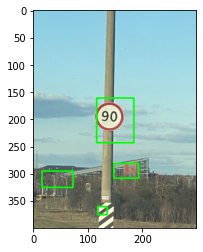

In [356]:
raw_img_copy = raw_img.copy()
for i in crops:
    crop = i[1]
    (x, y, w, h) = i[0]
    H, W = crop.shape[:2]
    img = cv2.resize(crop, (input_dim, input_dim))
    img = (img - 127.5) / 127.5
    
    prediction = pnet.predict(np.array([img]))
    confidence = prediction[0][0][0][0]
    confidence = confidence[np.argmax(confidence)]
    print(confidence)
    bbox = prediction[1][0][0][0]
    # if(confidence < 0.8):continue
    
    x_,y_,w,h = (bbox * np.array([W, H, W, H])).astype('uint8')
    x+=x_
    y+=y_
    
    crop = cv2.rectangle(raw_img_copy, (x, y), (x+w, y+h), (0,255,0), 2)
    
plt.imshow(raw_img_copy)
plt.show()